In [ ]:
# BrainStrom 2022
# Tutorial for classification with Neural nework (recurrent network)
# Resources:
# - https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
# AK, June-26-2022
# =========================================================================
%reset -f
import os, sys
from pprint import pprint as pp

# Define paths 
DIR_HERE = os.path.dirname(os.path.realpath("__file__"))
sys.path.append('../Others')

# Load basic modules 
import numpy as np
import matplotlib.pyplot as plt

# Load PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from torchvision import datasets, transforms

%who

DIR_HERE	 F	 L_default_weights	 Trainer	 Variable	 datasets	 nn	 np	 optim	 
os	 plt	 pp	 summary	 sys	 torch	 transforms	 


In [18]:
# -----------------------------
# Step0: Before we start... 
# -----------------------------

# What is MNIST dataset?
# http://yann.lecun.com/exdb/mnist/

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device used:", device)


Device used: cpu


In [19]:
# -----------------------------
# Step1: Prepare data
# -----------------------------

# Define "transform", which adjusts data 
# https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html
transform = transforms.Compose(
    [transforms.ToTensor(),                      # [H, W, C] -> [C, H, W]
     transforms.Normalize((0.5, ), (0.5, ))])    # normalize (mean =.5, sd = .5)


# Load (download for the first run) MNIST data
# Each image (C = channel, H = height, W = width) = (1, 28, 28) = 784 pixels
# https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST

#Train data (channel, height, width) = (1,28,28) 60000 images
train_dataset = datasets.MNIST(root='./data', 
                                        train = True, # Get training dataset
                                        download = True,
                                        transform = transform)

#Test data (channel, height, width) = (1,28,28) 10000 images
test_dataset = datasets.MNIST(root='./data', 
                                        train = False, # Get test dataset
                                        download = True, 
                                        transform = transform)

# Data too large?
# RandomSubsetSampler

image size =  torch.Size([1, 28, 28])
labels =  5


Text(0.5, 1.0, 'Label = 5')

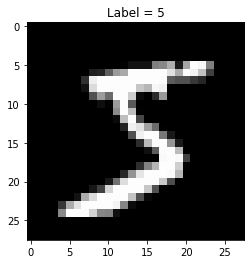

In [6]:
# Checking data and iteractor behavior
batch_iterator = iter(train_dataset) 
image, label = next(batch_iterator) 
print("image size = ", image.size())
print("labels = ", label)

plt.imshow(image[0].numpy().reshape(28,28), cmap='gray')
plt.title("Label = %d" % (label))

In [17]:
# -----------------------------
# Step 2: Define model
# -----------------------------


#------------------------------
# Define hyperparameters
n_epochs = 3            # how many times to repeat learning epochs
n_batch = 60           # how many examples to give in one epoch
learning_rate = .001    # learning rate of the oprimizer

# Layer properties
n_time = 28             # use heigh of image as sequential input
n_input = 28            # use width of image as features (input)
n_output = 10           # number of target (i.e., unique hand-written numbers)
n_rnn_layers = 1        # number of rnn layers stacked
n_units_hidden = 128    # number of hidden units
rnn_nl = 'relu'         # nonlinear update function of rnn layer


#------------------------------
# Define neural network model (dense feedforward network)
class Net(nn.Module):
    def __init__(self, n_time, n_input, n_output, n_units_hidden, n_rnn_layers, rnn_nl):
        # Initialize module
        super(Net, self).__init__()
        self.n_time = n_time
        self.n_input = n_input
        self.n_output = n_output
        self.n_units_hidden = n_units_hidden
        self.n_rnn_layers = n_rnn_layers
        
        # Prepare layers
        self.rnn = nn.RNN(n_input, n_units_hidden, nonlinearity = rnn_nl, dropout = 0.0, batch_first = True)
        self.fc = nn.Linear(n_units_hidden, n_output)
        
        # Initialize weights (to use defalt comment out all)
        #self.apply(self._init_weights)
        #self.apply(L_default_weights) # from PyTorch_util
        
    def _init_weights(self, m):
        print("To modify initial weights modify this part")
        raise NotImplementedError()
        
    def _set_state(self):
        weight = next(self.parameters()).data
        return Variable(weight.new(self.n_rnn_layers, self.n_batch, self.n_units_hidden).zero_())
    
    def forward(self, x):  
        # Initialize hidden state
        self.n_batch = x.shape[0] # batch_first = True
        self.h_state = self._set_state()
        
        # Transform data: (Batch, Time, Input)
        x = x.view(self.n_batch, self.n_time, self.n_input)
        
        # Connect layers and pass on to activation functions
        #(rnn_out) = (batch, time, hidden_size)
        #(h_n) =  (num_layers, batch, hidden_size)
        rnn_out, h_n = self.rnn(x, self.h_state) 
        x = h_n[-1, :, :]  # get last state of the hidden layer
        x = self.fc(x)
        return x
        
# Instantiate model
model = Net(n_time, n_input, n_output, n_units_hidden, n_rnn_layers, rnn_nl).to(device)
print(model)
summary(model, verbose = 2)
# summary(model, (n_batch, n_input, n_units_hidden), verbose = 2, col_width=16, col_names=["kernel_size", "output_size", "num_params"])

#------------------------------
# Define loss function
# CrossEntropyLoss = softmax + cross entropy error
criterion = nn.CrossEntropyLoss()

#------------------------------
# Define optimier
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

#------------------------------
# Define data loader, which generates batch efficiently in PyTorch
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# https://blog.paperspace.com/dataloaders-abstractions-pytorch/

# Data loader for training
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size = n_batch,
                                            shuffle = True)

#Data loader for testing
test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                            batch_size = n_batch,
                                            shuffle = False)

# vars(model.rnn)

NameError: name 'device' is not defined

In [193]:
# -----------------------------
# Step 3: Train model
# -----------------------------

#------------------------------
# change model as "training mode"
model.train()  

# Loop over n_epoch times
for epoch in range(n_epochs): 
    loss_sum = 0
    acc_sum = 0

    for inputs, labels in train_dataloader:        
        # CPU/GPU stuff (don't worry)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Initialize gradient of optimizer
        optimizer.zero_grad()

        # Forward path
        outputs = model(inputs)
        
        # Calculate loss: difference between output and label
        loss = criterion(outputs, labels)
        
        # Keep track of the progress of learning
        loss_sum += loss
        _, preds = torch.max(outputs, 1) # prediction = max softmax output
        acc_sum += torch.sum(preds == labels.data)

        # Backward path (Backpropagation!)
        loss.backward()

        # Update weights
        optimizer.step()

    # Display learning progress
    epoch_loss = loss_sum.item() / len(train_dataloader) # cumulative loss/ batch size
    epoch_acc = acc_sum.double() / len(train_dataloader.dataset) # cummlative count of correct prediction / data size
    print(f"Epoch: {epoch+1}/{n_epochs}, Loss: {epoch_loss}, Acc: {epoch_acc}")

    # Save weights
    #torch.save(model.state_dict(), 'model_weights.pth')

Epoch: 1/5, Loss: 0.8071481323242188, Acc: 0.7265
Epoch: 2/5, Loss: 0.32360336303710935, Acc: 0.9019166666666667
Epoch: 3/5, Loss: 0.22955712890625, Acc: 0.93175
Epoch: 4/5, Loss: 0.19020013427734375, Acc: 0.9434333333333333
Epoch: 5/5, Loss: 0.1607078857421875, Acc: 0.9526


In [8]:
# Step 4: Evaluate model
# -----------------------------

# Prepare test data to handle easily 
batch_iterator = iter(test_dataloader) # Make iterator out ot test_dataloader
images, labels = next(batch_iterator)  # Get first group of test batch
model.eval()  # change model as "evaluating mode"

# Make predictions to one test batch
with torch.set_grad_enabled(False):    # stop calculating gradient (stop learning)
    outputs = model(images)            # forward path
    _, preds = torch.max(outputs, 1)   # make prediction (take max of softmax function)

    
# Plot predicted label and correct label
_, axs = plt.subplots(5, 2, figsize=(20, 20))
axs = axs.flatten()

for i in range(len(preds)): 
    axs[i].imshow(images[i].numpy().reshape(28,28), cmap='gray')
    axs[i].title.set_text("Label: Target={}, Predict={}".format(labels[i].numpy(), preds[i].numpy()))
    

plt.show()